In [2]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time
import traceback

In [3]:
data_os = pd.read_csv('data_train_os.csv')

In [4]:
test_os = pd.read_csv('data_test_os.csv')

In [5]:
data_os = data_os.drop(columns=['Unnamed: 0'], errors='ignore')
test_os = test_os.drop(columns=['Unnamed: 0'], errors='ignore')

In [6]:
def reduce_mem_usage(df, verbose=True):
    """
    Reduce memory usage of a DataFrame by downcasting numeric columns
    and converting object columns to category where appropriate
    Datetime columns are preseved(skip)

    Paremeters:
    - df (pd.DataFrame): The input DataFrame to optimize
    - verbose (bool): If True, prints memory usage info
                      If False, just execute the operation

    Returns:
    - df (pd.DataFrame): Optimized DataFrame
    """
    # Calculate memory usage before optimization
    # 'deep=True' ensures object-type columns (e.g. strings) are fully measured
    # Divide by 1024^2 to convert bytes to megabytes
    start_mem = df.memory_usage(deep=True).sum() / 1024**2

    # Iterate through each columns in the DataFrame
    for col in df.columns:
        col_type = df[col].dtype

        # Skip datetime columns to avoid corrupting temporal data
        if pd.api.types.is_datetime64_any_dtype(col_type):
            continue

        # If the column is numeric(integer or float)
        elif pd.api.types.is_numeric_dtype(col_type):
            c_min = df[col].min()
            c_max = df[col].max()

            # If the column is an integer type
            if pd.api.types.is_integer_dtype(col_type):
                # Try downcasting to the smallest possible integer type
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)

            # If the column is an float type
            else:
                # Try downcasting to float16, float32, or keep as float64
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                #elif c_min >= np.finfo(np.float64).min and c_max <= np.finfo(np.float64).max:
                else:
                    df[col] = df[col].astype(np.float64)
        # If the column is an object type
        elif pd.api.types.is_object_dtype(col_type):
            num_unique = df[col].nunique()
            num_total = len(df[col])
            # if the unique ratio is below 50%, convert to category for memory
            if num_unique / num_total < 0.5:
                df[col] = df[col].astype('category')

        # Other types are not modified

    # Calculate memory usage after optimization
    end_mem = df.memory_usage(deep=True).sum() / 1024**2

    if verbose:
        # Print summary of memory usage before and after optimization
        print(f"Memory usage before optimization: {start_mem:.2f} MB")
        print(f"Memory usage after optimization: {end_mem:.2f} MB")
        print(f"Reduced by: {100 * (start_mem - end_mem) / start_mem:.1f}%")

    return df

In [7]:
data_os = reduce_mem_usage(data_os)
test_os = reduce_mem_usage(test_os)

Memory usage before optimization: 223.87 MB
Memory usage after optimization: 53.53 MB
Reduced by: 76.1%
Memory usage before optimization: 68.66 MB
Memory usage after optimization: 16.59 MB
Reduced by: 75.8%


In [8]:
y_os = data_os['isDefault']
X_os = data_os.drop(['isDefault'], axis=1)
print(y_os.shape, X_os.shape, test_os.shape)

(637893,) (637893, 45) (200000, 45)


In [31]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Step 1: Train/Validation Split
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(
    X_os, y_os, test_size=0.2, random_state=42, stratify=y_os
)

# Step 2: Train baseline model
baseline_model = lgb.LGBMClassifier(objective='binary', random_state=42)
baseline_model.fit(X_train_base, y_train_base)

# Step 3: Evaluate
y_val_pred_proba = baseline_model.predict_proba(X_val_base)[:, 1]
auc_baseline = roc_auc_score(y_val_base, y_val_pred_proba)
print(f"🔹 Baseline AUC: {auc_baseline:.5f}")

🔹 Baseline AUC: 0.72737


In [34]:
import optuna
from sklearn.model_selection import StratifiedKFold
from lightgbm import early_stopping, log_evaluation


def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'random_state': 42,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []
    for train_idx, valid_idx in skf.split(X_os, y_os):
        X_train_fold, y_train_fold = X_os.iloc[train_idx], y_os.iloc[train_idx]
        X_valid_fold, y_valid_fold = X_os.iloc[valid_idx], y_os.iloc[valid_idx]

        model = lgb.LGBMClassifier(**params, n_estimators=1000)
        model.fit(
            X_train_fold, y_train_fold,
            eval_set=[(X_valid_fold, y_valid_fold)],
            eval_metric='auc',
            callbacks=[
                    early_stopping(100),
                    log_evaluation(0)  # 不输出每轮日志，可调节为 100 或其他
                ]
        )
        y_valid_pred = model.predict_proba(X_valid_fold)[:, 1]
        aucs.append(roc_auc_score(y_valid_fold, y_valid_pred))

    return np.mean(aucs)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # 可以调高为50+

[I 2025-05-14 10:57:24,594] A new study created in memory with name: no-name-0a010f23-d8a7-491f-9c65-44a06d097a08


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[275]	valid_0's auc: 0.730132
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[286]	valid_0's auc: 0.732765
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[321]	valid_0's auc: 0.732137
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[303]	valid_0's auc: 0.731047
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[362]	valid_0's auc: 0.731855


[I 2025-05-14 11:00:27,067] Trial 0 finished with value: 0.7315871358917931 and parameters: {'learning_rate': 0.05509962651222114, 'num_leaves': 188, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.8435505000060838, 'colsample_bytree': 0.8607531231470755, 'reg_alpha': 3.6255669072128196, 'reg_lambda': 2.3747633741667524}. Best is trial 0 with value: 0.7315871358917931.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[659]	valid_0's auc: 0.731026
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[541]	valid_0's auc: 0.733526
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[768]	valid_0's auc: 0.732772
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[523]	valid_0's auc: 0.732425
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[670]	valid_0's auc: 0.732959


[I 2025-05-14 11:01:36,497] Trial 1 finished with value: 0.7325416434193567 and parameters: {'learning_rate': 0.09621159415387441, 'num_leaves': 180, 'max_depth': 5, 'min_child_samples': 74, 'subsample': 0.6999357708978662, 'colsample_bytree': 0.7732151050040179, 'reg_alpha': 3.714943932478235, 'reg_lambda': 1.302490793211667}. Best is trial 1 with value: 0.7325416434193567.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[175]	valid_0's auc: 0.730308
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[184]	valid_0's auc: 0.7321
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[167]	valid_0's auc: 0.731572
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[197]	valid_0's auc: 0.731006
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[204]	valid_0's auc: 0.731532


[I 2025-05-14 11:03:46,326] Trial 2 finished with value: 0.7313033161593626 and parameters: {'learning_rate': 0.09245204000080783, 'num_leaves': 185, 'max_depth': 10, 'min_child_samples': 56, 'subsample': 0.6948443837188956, 'colsample_bytree': 0.5921298386536411, 'reg_alpha': 3.820806064954705, 'reg_lambda': 2.1815327417301567}. Best is trial 1 with value: 0.7325416434193567.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	valid_0's auc: 0.729646
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[142]	valid_0's auc: 0.732385
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[202]	valid_0's auc: 0.731307
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[147]	valid_0's auc: 0.73103
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[124]	valid_0's auc: 0.730846


[I 2025-05-14 11:05:22,737] Trial 3 finished with value: 0.731042668400374 and parameters: {'learning_rate': 0.09546564924938901, 'num_leaves': 147, 'max_depth': 15, 'min_child_samples': 77, 'subsample': 0.5090456966024475, 'colsample_bytree': 0.8645553033852547, 'reg_alpha': 2.217501750969343, 'reg_lambda': 4.629345337020856}. Best is trial 1 with value: 0.7325416434193567.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.731015
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.733527
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's auc: 0.73246
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's auc: 0.732001
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.732834


[I 2025-05-14 11:07:06,649] Trial 4 finished with value: 0.7323673399172391 and parameters: {'learning_rate': 0.043992113602932384, 'num_leaves': 97, 'max_depth': 5, 'min_child_samples': 35, 'subsample': 0.5785036773094903, 'colsample_bytree': 0.5371613967967782, 'reg_alpha': 1.3474036373019094, 'reg_lambda': 4.7573877998237615}. Best is trial 1 with value: 0.7325416434193567.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[978]	valid_0's auc: 0.731739
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[808]	valid_0's auc: 0.733609
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's auc: 0.733
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[946]	valid_0's auc: 0.732522
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[979]	valid_0's auc: 0.733041


[I 2025-05-14 11:13:49,907] Trial 5 finished with value: 0.7327821852500026 and parameters: {'learning_rate': 0.019658132911472132, 'num_leaves': 136, 'max_depth': 14, 'min_child_samples': 55, 'subsample': 0.5411580702250736, 'colsample_bytree': 0.6217471744650476, 'reg_alpha': 2.6523182902911464, 'reg_lambda': 1.7188087794090867}. Best is trial 5 with value: 0.7327821852500026.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[826]	valid_0's auc: 0.731781
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[752]	valid_0's auc: 0.733673
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[966]	valid_0's auc: 0.733325
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[700]	valid_0's auc: 0.733084
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[815]	valid_0's auc: 0.733118


[I 2025-05-14 11:17:15,373] Trial 6 finished with value: 0.732996510143299 and parameters: {'learning_rate': 0.05837526826659934, 'num_leaves': 48, 'max_depth': 7, 'min_child_samples': 78, 'subsample': 0.533067736432638, 'colsample_bytree': 0.5372717263560756, 'reg_alpha': 4.910105638707654, 'reg_lambda': 1.7161342894255183}. Best is trial 6 with value: 0.732996510143299.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[203]	valid_0's auc: 0.729182
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[225]	valid_0's auc: 0.731725
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[238]	valid_0's auc: 0.731048
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[222]	valid_0's auc: 0.730564
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[198]	valid_0's auc: 0.731193


[I 2025-05-14 11:20:00,874] Trial 7 finished with value: 0.7307422877820942 and parameters: {'learning_rate': 0.07567571911616539, 'num_leaves': 160, 'max_depth': 11, 'min_child_samples': 51, 'subsample': 0.7977753017355076, 'colsample_bytree': 0.9938498837242629, 'reg_alpha': 2.363728995143358, 'reg_lambda': 0.17186834764571224}. Best is trial 6 with value: 0.732996510143299.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[890]	valid_0's auc: 0.731543
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[781]	valid_0's auc: 0.734005
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[841]	valid_0's auc: 0.733205
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[897]	valid_0's auc: 0.732275
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[751]	valid_0's auc: 0.733298


[I 2025-05-14 11:22:58,185] Trial 8 finished with value: 0.7328653687904111 and parameters: {'learning_rate': 0.06344778621400904, 'num_leaves': 176, 'max_depth': 6, 'min_child_samples': 80, 'subsample': 0.9304208473364255, 'colsample_bytree': 0.5959327667179506, 'reg_alpha': 2.809225684910553, 'reg_lambda': 4.387172193537267}. Best is trial 6 with value: 0.732996510143299.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[592]	valid_0's auc: 0.731195
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[587]	valid_0's auc: 0.733417
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[583]	valid_0's auc: 0.732652
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[521]	valid_0's auc: 0.731753
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[570]	valid_0's auc: 0.732497


[I 2025-05-14 11:26:14,164] Trial 9 finished with value: 0.7323025885191722 and parameters: {'learning_rate': 0.057194164887472615, 'num_leaves': 149, 'max_depth': 7, 'min_child_samples': 72, 'subsample': 0.9069369809931793, 'colsample_bytree': 0.6608294479521167, 'reg_alpha': 0.9894222982514883, 'reg_lambda': 2.103693505878762}. Best is trial 6 with value: 0.732996510143299.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.727191
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.728946
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.727947
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.727965
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.727911


[I 2025-05-14 11:27:14,850] Trial 10 finished with value: 0.7279918213111788 and parameters: {'learning_rate': 0.03296748194068984, 'num_leaves': 34, 'max_depth': 3, 'min_child_samples': 99, 'subsample': 0.6215491164836237, 'colsample_bytree': 0.7243925433366307, 'reg_alpha': 4.4550372192733105, 'reg_lambda': 3.5801252609807297}. Best is trial 6 with value: 0.732996510143299.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[610]	valid_0's auc: 0.73141
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[522]	valid_0's auc: 0.733845
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[604]	valid_0's auc: 0.732805
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[620]	valid_0's auc: 0.732801
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[636]	valid_0's auc: 0.732683


[I 2025-05-14 11:28:39,851] Trial 11 finished with value: 0.7327088281901284 and parameters: {'learning_rate': 0.06892496166917196, 'num_leaves': 66, 'max_depth': 8, 'min_child_samples': 94, 'subsample': 0.9848419774832275, 'colsample_bytree': 0.5062419085337777, 'reg_alpha': 4.89439967517664, 'reg_lambda': 3.4747811275172755}. Best is trial 6 with value: 0.732996510143299.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's auc: 0.731245
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.733422
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[943]	valid_0's auc: 0.732413
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[944]	valid_0's auc: 0.731998
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[972]	valid_0's auc: 0.732214


[I 2025-05-14 11:29:41,676] Trial 12 finished with value: 0.7322584856360111 and parameters: {'learning_rate': 0.06587705088581182, 'num_leaves': 22, 'max_depth': 6, 'min_child_samples': 85, 'subsample': 0.984485062771072, 'colsample_bytree': 0.569506073746509, 'reg_alpha': 0.17620644308718214, 'reg_lambda': 3.350126035982192}. Best is trial 6 with value: 0.732996510143299.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.73047
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.732194
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.731162
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.731078
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.731466


[I 2025-05-14 11:30:20,732] Trial 13 finished with value: 0.7312737386036813 and parameters: {'learning_rate': 0.0796430363278724, 'num_leaves': 106, 'max_depth': 3, 'min_child_samples': 65, 'subsample': 0.8723035029351418, 'colsample_bytree': 0.6696408794157915, 'reg_alpha': 3.1649469869847264, 'reg_lambda': 0.992556969814538}. Best is trial 6 with value: 0.732996510143299.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[822]	valid_0's auc: 0.731644
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[869]	valid_0's auc: 0.733906
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[731]	valid_0's auc: 0.732788
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[882]	valid_0's auc: 0.733018
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[801]	valid_0's auc: 0.733027


[I 2025-05-14 11:32:23,925] Trial 14 finished with value: 0.7328766869936689 and parameters: {'learning_rate': 0.038647839440869546, 'num_leaves': 74, 'max_depth': 9, 'min_child_samples': 86, 'subsample': 0.7558447174456933, 'colsample_bytree': 0.5029126629263135, 'reg_alpha': 1.5537850716217738, 'reg_lambda': 2.9595726295246587}. Best is trial 6 with value: 0.732996510143299.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[744]	valid_0's auc: 0.73138
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[821]	valid_0's auc: 0.734028
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[799]	valid_0's auc: 0.732751
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[754]	valid_0's auc: 0.73271
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[948]	valid_0's auc: 0.733162


[I 2025-05-14 11:34:17,333] Trial 15 finished with value: 0.732806179888358 and parameters: {'learning_rate': 0.042374237674446355, 'num_leaves': 67, 'max_depth': 9, 'min_child_samples': 89, 'subsample': 0.7513436924252208, 'colsample_bytree': 0.5216872885219559, 'reg_alpha': 1.62009710114434, 'reg_lambda': 3.0086375445147646}. Best is trial 6 with value: 0.732996510143299.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.730482
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[968]	valid_0's auc: 0.732864
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.731635
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.731519
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.732015


[I 2025-05-14 11:36:17,534] Trial 16 finished with value: 0.7317028739934336 and parameters: {'learning_rate': 0.016928153912398568, 'num_leaves': 60, 'max_depth': 13, 'min_child_samples': 65, 'subsample': 0.6669609342624769, 'colsample_bytree': 0.7276320902627447, 'reg_alpha': 0.3581109877156292, 'reg_lambda': 2.8139161770237595}. Best is trial 6 with value: 0.732996510143299.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[788]	valid_0's auc: 0.731249
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[950]	valid_0's auc: 0.733955
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[924]	valid_0's auc: 0.733116
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[874]	valid_0's auc: 0.732698
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[856]	valid_0's auc: 0.733089


[I 2025-05-14 11:38:31,628] Trial 17 finished with value: 0.7328215774970992 and parameters: {'learning_rate': 0.03340598552774781, 'num_leaves': 83, 'max_depth': 8, 'min_child_samples': 42, 'subsample': 0.7716441049762752, 'colsample_bytree': 0.5031515855169992, 'reg_alpha': 1.8173021514639367, 'reg_lambda': 0.5554221780502484}. Best is trial 6 with value: 0.732996510143299.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's auc: 0.730777
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[952]	valid_0's auc: 0.733619
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[839]	valid_0's auc: 0.732469
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[954]	valid_0's auc: 0.732149
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[954]	valid_0's auc: 0.732435


[I 2025-05-14 11:40:01,698] Trial 18 finished with value: 0.7322895129953932 and parameters: {'learning_rate': 0.042075572202879996, 'num_leaves': 45, 'max_depth': 12, 'min_child_samples': 100, 'subsample': 0.6271253218642643, 'colsample_bytree': 0.8248323801567223, 'reg_alpha': 0.8718838780850833, 'reg_lambda': 1.5928126089365993}. Best is trial 6 with value: 0.732996510143299.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[846]	valid_0's auc: 0.731631
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[842]	valid_0's auc: 0.733931
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's auc: 0.733332
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.732806
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[965]	valid_0's auc: 0.733368


[I 2025-05-14 11:42:59,069] Trial 19 finished with value: 0.7330137230928828 and parameters: {'learning_rate': 0.02755445115221073, 'num_leaves': 120, 'max_depth': 10, 'min_child_samples': 87, 'subsample': 0.809633911431739, 'colsample_bytree': 0.6521879988724538, 'reg_alpha': 4.45586803909401, 'reg_lambda': 3.9713369519838464}. Best is trial 19 with value: 0.7330137230928828.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.730857
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.733383
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.732472
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.731984
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.732525


[I 2025-05-14 11:46:11,721] Trial 20 finished with value: 0.7322441344996319 and parameters: {'learning_rate': 0.012406141125856342, 'num_leaves': 123, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.823505372052781, 'colsample_bytree': 0.6815150026978054, 'reg_alpha': 4.840846581100443, 'reg_lambda': 3.842039589458782}. Best is trial 19 with value: 0.7330137230928828.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.731718
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[925]	valid_0's auc: 0.734343
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.732918
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[991]	valid_0's auc: 0.73301
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's auc: 0.733443


[I 2025-05-14 11:48:40,565] Trial 21 finished with value: 0.733086591749656 and parameters: {'learning_rate': 0.027637910573266755, 'num_leaves': 84, 'max_depth': 9, 'min_child_samples': 90, 'subsample': 0.7288187701776632, 'colsample_bytree': 0.5641763697652115, 'reg_alpha': 4.397561610641622, 'reg_lambda': 4.029838499075822}. Best is trial 21 with value: 0.733086591749656.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.731508
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.733962
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.733022
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.732859
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's auc: 0.733134


[I 2025-05-14 11:50:58,181] Trial 22 finished with value: 0.7328972207479532 and parameters: {'learning_rate': 0.025286765896069204, 'num_leaves': 89, 'max_depth': 8, 'min_child_samples': 90, 'subsample': 0.7115669996685239, 'colsample_bytree': 0.6328258867391034, 'reg_alpha': 4.385207299641527, 'reg_lambda': 4.176099705471348}. Best is trial 21 with value: 0.733086591749656.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[506]	valid_0's auc: 0.731576
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[388]	valid_0's auc: 0.733231
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[415]	valid_0's auc: 0.732937
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[418]	valid_0's auc: 0.732755
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[370]	valid_0's auc: 0.733049


[I 2025-05-14 11:52:38,950] Trial 23 finished with value: 0.7327098272782461 and parameters: {'learning_rate': 0.052115654515747484, 'num_leaves': 117, 'max_depth': 10, 'min_child_samples': 64, 'subsample': 0.6078668555874858, 'colsample_bytree': 0.5684619564393529, 'reg_alpha': 4.256850420137756, 'reg_lambda': 4.98618229742182}. Best is trial 21 with value: 0.733086591749656.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.731216
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's auc: 0.733715
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.732768
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.732605
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.732976


[I 2025-05-14 11:54:21,579] Trial 24 finished with value: 0.7326559889287672 and parameters: {'learning_rate': 0.027198973217762858, 'num_leaves': 51, 'max_depth': 7, 'min_child_samples': 82, 'subsample': 0.5619025666671469, 'colsample_bytree': 0.5641864134510672, 'reg_alpha': 4.952670308288418, 'reg_lambda': 4.11958425340637}. Best is trial 21 with value: 0.733086591749656.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[714]	valid_0's auc: 0.731278
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[405]	valid_0's auc: 0.733775
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[810]	valid_0's auc: 0.732786
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[438]	valid_0's auc: 0.73268
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[596]	valid_0's auc: 0.732943


[I 2025-05-14 11:56:16,617] Trial 25 finished with value: 0.7326924874809022 and parameters: {'learning_rate': 0.04891844451387793, 'num_leaves': 99, 'max_depth': 12, 'min_child_samples': 94, 'subsample': 0.6628331536682703, 'colsample_bytree': 0.627891532037271, 'reg_alpha': 4.143848567017828, 'reg_lambda': 3.883641889974857}. Best is trial 21 with value: 0.733086591749656.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.731823
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[989]	valid_0's auc: 0.733866
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[991]	valid_0's auc: 0.733125
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.73287
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.733496


[I 2025-05-14 11:58:23,580] Trial 26 finished with value: 0.7330358648864177 and parameters: {'learning_rate': 0.029370067018227555, 'num_leaves': 81, 'max_depth': 7, 'min_child_samples': 72, 'subsample': 0.8010849875077161, 'colsample_bytree': 0.547438896707137, 'reg_alpha': 3.153871266490947, 'reg_lambda': 2.774694622786832}. Best is trial 21 with value: 0.733086591749656.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.73049
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.733084
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.732164
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.731706
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.732121


[I 2025-05-14 12:01:48,141] Trial 27 finished with value: 0.7319130259874121 and parameters: {'learning_rate': 0.010320601423309414, 'num_leaves': 126, 'max_depth': 11, 'min_child_samples': 69, 'subsample': 0.7975065491954961, 'colsample_bytree': 0.6953780352024703, 'reg_alpha': 3.342664827975225, 'reg_lambda': 3.1862309822989685}. Best is trial 21 with value: 0.733086591749656.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.731106
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's auc: 0.733626
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.733133
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's auc: 0.732356
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[929]	valid_0's auc: 0.732864


[I 2025-05-14 12:04:03,077] Trial 28 finished with value: 0.7326169137343548 and parameters: {'learning_rate': 0.025028387091759422, 'num_leaves': 82, 'max_depth': 9, 'min_child_samples': 93, 'subsample': 0.8610740723442323, 'colsample_bytree': 0.7780596798402776, 'reg_alpha': 3.254807786307329, 'reg_lambda': 2.6078274715300322}. Best is trial 21 with value: 0.733086591749656.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.730575
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.732703
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.731593
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.731489
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.732091


[I 2025-05-14 12:05:12,547] Trial 29 finished with value: 0.7316900069907424 and parameters: {'learning_rate': 0.03193438466390986, 'num_leaves': 102, 'max_depth': 5, 'min_child_samples': 34, 'subsample': 0.8319925938900744, 'colsample_bytree': 0.5971184332955575, 'reg_alpha': 3.9405680472911544, 'reg_lambda': 3.6850661330646073}. Best is trial 21 with value: 0.733086591749656.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.731405
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[987]	valid_0's auc: 0.733802
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.733235
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[975]	valid_0's auc: 0.732974
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[941]	valid_0's auc: 0.733159


[I 2025-05-14 12:08:21,015] Trial 30 finished with value: 0.7329149573822467 and parameters: {'learning_rate': 0.01963386612571563, 'num_leaves': 116, 'max_depth': 12, 'min_child_samples': 83, 'subsample': 0.7250805751062324, 'colsample_bytree': 0.649468716439821, 'reg_alpha': 2.9742842304563073, 'reg_lambda': 4.165103166276162}. Best is trial 21 with value: 0.733086591749656.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[916]	valid_0's auc: 0.73182
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[707]	valid_0's auc: 0.733991
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[746]	valid_0's auc: 0.732949
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[728]	valid_0's auc: 0.732701
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[723]	valid_0's auc: 0.73319


[I 2025-05-14 12:09:44,319] Trial 31 finished with value: 0.732930217505911 and parameters: {'learning_rate': 0.05898344125049914, 'num_leaves': 47, 'max_depth': 7, 'min_child_samples': 76, 'subsample': 0.7933878121365596, 'colsample_bytree': 0.5471852759572614, 'reg_alpha': 4.620210458199443, 'reg_lambda': 1.8930520167480882}. Best is trial 21 with value: 0.733086591749656.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's auc: 0.731527
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[991]	valid_0's auc: 0.734336
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.733554
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[823]	valid_0's auc: 0.732689
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.73327


[I 2025-05-14 12:11:20,131] Trial 32 finished with value: 0.7330753917591767 and parameters: {'learning_rate': 0.04947798382828803, 'num_leaves': 76, 'max_depth': 6, 'min_child_samples': 70, 'subsample': 0.9060401088569086, 'colsample_bytree': 0.5425041331362989, 'reg_alpha': 3.6386629380801914, 'reg_lambda': 2.457631147752073}. Best is trial 21 with value: 0.733086591749656.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[992]	valid_0's auc: 0.729629
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.731756
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.730831
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.730668
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.730919


[I 2025-05-14 12:12:12,675] Trial 33 finished with value: 0.730760671261347 and parameters: {'learning_rate': 0.03726423855247149, 'num_leaves': 88, 'max_depth': 4, 'min_child_samples': 69, 'subsample': 0.893790778850132, 'colsample_bytree': 0.6018003250341122, 'reg_alpha': 3.559836365581462, 'reg_lambda': 2.4284611685326745}. Best is trial 21 with value: 0.733086591749656.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's auc: 0.731598
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[942]	valid_0's auc: 0.734136
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[988]	valid_0's auc: 0.733138
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[971]	valid_0's auc: 0.732799
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[990]	valid_0's auc: 0.733269


[I 2025-05-14 12:13:49,234] Trial 34 finished with value: 0.7329879861865279 and parameters: {'learning_rate': 0.04939205727599271, 'num_leaves': 73, 'max_depth': 6, 'min_child_samples': 62, 'subsample': 0.9425139601152129, 'colsample_bytree': 0.564964710271577, 'reg_alpha': 3.568458976298501, 'reg_lambda': 2.6522805882384706}. Best is trial 21 with value: 0.733086591749656.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.730755
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[887]	valid_0's auc: 0.733382
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.732846
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.732285
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.732586


[I 2025-05-14 12:16:14,419] Trial 35 finished with value: 0.7323708135684412 and parameters: {'learning_rate': 0.025731695289234663, 'num_leaves': 93, 'max_depth': 9, 'min_child_samples': 73, 'subsample': 0.8224160478413113, 'colsample_bytree': 0.9147207513647319, 'reg_alpha': 3.8695444314872542, 'reg_lambda': 2.2235870208756108}. Best is trial 21 with value: 0.733086591749656.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.731771
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[786]	valid_0's auc: 0.734015
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[863]	valid_0's auc: 0.732983
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[909]	valid_0's auc: 0.732912
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's auc: 0.733253


[I 2025-05-14 12:18:59,959] Trial 36 finished with value: 0.7329869653309403 and parameters: {'learning_rate': 0.02978082195785994, 'num_leaves': 108, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.7336318382691842, 'colsample_bytree': 0.6087103238173324, 'reg_alpha': 4.03294055657741, 'reg_lambda': 1.1941420151780842}. Best is trial 21 with value: 0.733086591749656.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.731535
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.733647
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.733055
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.732696
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.733204


[I 2025-05-14 12:21:59,482] Trial 37 finished with value: 0.732827398037321 and parameters: {'learning_rate': 0.020290412739008286, 'num_leaves': 132, 'max_depth': 8, 'min_child_samples': 54, 'subsample': 0.8509425389677742, 'colsample_bytree': 0.5410689532206452, 'reg_alpha': 3.629402229916264, 'reg_lambda': 4.693196198226854}. Best is trial 21 with value: 0.733086591749656.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.729893
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.731672
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.730726
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.730572
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.730937


[I 2025-05-14 12:22:50,505] Trial 38 finished with value: 0.7307598248370009 and parameters: {'learning_rate': 0.036891151882684964, 'num_leaves': 79, 'max_depth': 4, 'min_child_samples': 59, 'subsample': 0.67492514678912, 'colsample_bytree': 0.5765297008740246, 'reg_alpha': 4.612230665944893, 'reg_lambda': 3.244212490219894}. Best is trial 21 with value: 0.733086591749656.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.731576
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[971]	valid_0's auc: 0.734184
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's auc: 0.733277
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[974]	valid_0's auc: 0.732747
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[895]	valid_0's auc: 0.733075


[I 2025-05-14 12:24:16,213] Trial 39 finished with value: 0.7329718648405071 and parameters: {'learning_rate': 0.04644875707157322, 'num_leaves': 199, 'max_depth': 6, 'min_child_samples': 79, 'subsample': 0.9474827662288601, 'colsample_bytree': 0.6374730854486736, 'reg_alpha': 2.6164886901378015, 'reg_lambda': 4.294325821156053}. Best is trial 21 with value: 0.733086591749656.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[873]	valid_0's auc: 0.731534
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[714]	valid_0's auc: 0.733759
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[729]	valid_0's auc: 0.73298
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[687]	valid_0's auc: 0.732369
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[837]	valid_0's auc: 0.733026


[I 2025-05-14 12:25:09,643] Trial 40 finished with value: 0.7327337440052901 and parameters: {'learning_rate': 0.089306620425368, 'num_leaves': 142, 'max_depth': 5, 'min_child_samples': 49, 'subsample': 0.888516705696885, 'colsample_bytree': 0.7091031550541571, 'reg_alpha': 2.9773401215643, 'reg_lambda': 4.466297699306925}. Best is trial 21 with value: 0.733086591749656.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[623]	valid_0's auc: 0.73139
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[835]	valid_0's auc: 0.734056
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[734]	valid_0's auc: 0.733165
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[743]	valid_0's auc: 0.732888
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[900]	valid_0's auc: 0.733311


[I 2025-05-14 12:26:41,638] Trial 41 finished with value: 0.73296203551581 and parameters: {'learning_rate': 0.05411142701815043, 'num_leaves': 58, 'max_depth': 7, 'min_child_samples': 77, 'subsample': 0.520646316115556, 'colsample_bytree': 0.5262737071316658, 'reg_alpha': 4.613679868487749, 'reg_lambda': 1.5232534065470114}. Best is trial 21 with value: 0.733086591749656.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[631]	valid_0's auc: 0.731217
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[780]	valid_0's auc: 0.733702
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[816]	valid_0's auc: 0.733373
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[674]	valid_0's auc: 0.732153
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[826]	valid_0's auc: 0.732876


[I 2025-05-14 12:27:51,854] Trial 42 finished with value: 0.7326641347731163 and parameters: {'learning_rate': 0.07157784346894722, 'num_leaves': 35, 'max_depth': 8, 'min_child_samples': 87, 'subsample': 0.7760676184140372, 'colsample_bytree': 0.5487985296758552, 'reg_alpha': 4.255237713500955, 'reg_lambda': 1.935320243036137}. Best is trial 21 with value: 0.733086591749656.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[804]	valid_0's auc: 0.731435
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[792]	valid_0's auc: 0.734184
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[834]	valid_0's auc: 0.73334
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[817]	valid_0's auc: 0.732716
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[774]	valid_0's auc: 0.733212


[I 2025-05-14 12:29:17,903] Trial 43 finished with value: 0.7329773183871555 and parameters: {'learning_rate': 0.06193686741122382, 'num_leaves': 163, 'max_depth': 6, 'min_child_samples': 69, 'subsample': 0.9173237095043758, 'colsample_bytree': 0.5904166295566023, 'reg_alpha': 4.485171077220135, 'reg_lambda': 2.2672691470054422}. Best is trial 21 with value: 0.733086591749656.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.730369
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.732697
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.731773
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.731422
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.731962


[I 2025-05-14 12:31:10,132] Trial 44 finished with value: 0.7316446118574037 and parameters: {'learning_rate': 0.01607252109369904, 'num_leaves': 58, 'max_depth': 7, 'min_child_samples': 80, 'subsample': 0.9604829493990349, 'colsample_bytree': 0.5262891859897623, 'reg_alpha': 2.185457942646964, 'reg_lambda': 1.3089532936869248}. Best is trial 21 with value: 0.733086591749656.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[618]	valid_0's auc: 0.73153
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[763]	valid_0's auc: 0.733716
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[500]	valid_0's auc: 0.73219
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[752]	valid_0's auc: 0.732353
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[588]	valid_0's auc: 0.73239


[I 2025-05-14 12:32:11,185] Trial 45 finished with value: 0.7324357211429094 and parameters: {'learning_rate': 0.0780183248899481, 'num_leaves': 35, 'max_depth': 11, 'min_child_samples': 74, 'subsample': 0.5963480464338173, 'colsample_bytree': 0.6185635407325105, 'reg_alpha': 3.769349879501847, 'reg_lambda': 0.7304223442766112}. Best is trial 21 with value: 0.733086591749656.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[490]	valid_0's auc: 0.730982
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[545]	valid_0's auc: 0.733718
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[480]	valid_0's auc: 0.73283
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[684]	valid_0's auc: 0.732613
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[489]	valid_0's auc: 0.73289


[I 2025-05-14 12:33:27,582] Trial 46 finished with value: 0.7326063906972605 and parameters: {'learning_rate': 0.05743198858495155, 'num_leaves': 70, 'max_depth': 9, 'min_child_samples': 95, 'subsample': 0.6910691601426597, 'colsample_bytree': 0.7658867389858597, 'reg_alpha': 4.813187390980481, 'reg_lambda': 2.035833238075686}. Best is trial 21 with value: 0.733086591749656.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.729691
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.731784
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.730606
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.730538
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.730868


[I 2025-05-14 12:34:37,480] Trial 47 finished with value: 0.7306972919393189 and parameters: {'learning_rate': 0.022432738503657432, 'num_leaves': 91, 'max_depth': 5, 'min_child_samples': 91, 'subsample': 0.8099189497806379, 'colsample_bytree': 0.5469997772679046, 'reg_alpha': 3.456687610627762, 'reg_lambda': 2.7923182955363712}. Best is trial 21 with value: 0.733086591749656.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's auc: 0.729705
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.731516
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.730686
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.730399
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.730902


[I 2025-05-14 12:35:30,396] Trial 48 finished with value: 0.7306416707487849 and parameters: {'learning_rate': 0.035543523757095546, 'num_leaves': 26, 'max_depth': 4, 'min_child_samples': 84, 'subsample': 0.6405762840811067, 'colsample_bytree': 0.5829513588720798, 'reg_alpha': 4.066044902115296, 'reg_lambda': 3.8121768985026376}. Best is trial 21 with value: 0.733086591749656.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[856]	valid_0's auc: 0.731236
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[690]	valid_0's auc: 0.733895
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[863]	valid_0's auc: 0.733003
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[868]	valid_0's auc: 0.732707
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[797]	valid_0's auc: 0.733439


[I 2025-05-14 12:38:02,442] Trial 49 finished with value: 0.7328559184913448 and parameters: {'learning_rate': 0.04053157059066798, 'num_leaves': 111, 'max_depth': 8, 'min_child_samples': 98, 'subsample': 0.8693654996179844, 'colsample_bytree': 0.5137273283383325, 'reg_alpha': 4.984541757509479, 'reg_lambda': 3.435791897031382}. Best is trial 21 with value: 0.733086591749656.


In [35]:
study.best_params

{'learning_rate': 0.027637910573266755,
 'num_leaves': 84,
 'max_depth': 9,
 'min_child_samples': 90,
 'subsample': 0.7288187701776632,
 'colsample_bytree': 0.5641763697652115,
 'reg_alpha': 4.397561610641622,
 'reg_lambda': 4.029838499075822}

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1465]	valid_0's auc: 0.732465


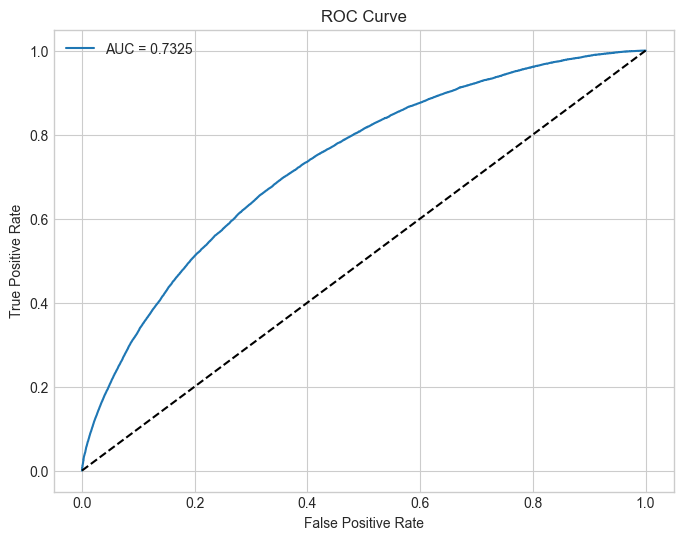

In [39]:
best_params = study.best_params.copy()
best_params.update({
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'random_state': 42,
})

# 最终模型训练
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_os, y_os, test_size=0.2, stratify=y_os, random_state=42
)

model = lgb.LGBMClassifier(**best_params, n_estimators=10000)
model.fit(
    X_train_final, y_train_final,
    eval_set=[(X_val_final, y_val_final)],
    eval_metric='auc',
    callbacks=[
               early_stopping(100),
               log_evaluation(0)  # 不输出每轮日志，可调节为 100 或其他
    ]
)

# ROC 曲线
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

y_val_pred = model.predict_proba(X_val_final)[:, 1]
fpr, tpr, _ = roc_curve(y_val_final, y_val_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_val_final, y_val_pred):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

 ### Phase2

In [43]:
best_params_phase1 = study.best_params.copy()
def lgb_objective_mid(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',  # This is the metric name
        'verbosity': -1,
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-5, 1e-1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7), # If subsample < 1.0, subsample_freq should be > 0
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0)
    }

    if params['boosting_type'] == 'dart':
        params['drop_rate'] = trial.suggest_float('drop_rate', 0.1, 0.5)
        params['skip_drop'] = trial.suggest_float('skip_drop', 0.1, 0.5)
    
    # Ensure subsample_freq is valid if subsample is less than 1.0
    if params['subsample'] < 1.0 and params['subsample_freq'] == 0:
        params['subsample_freq'] = 1 # Set to a default valid value like 1

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # Ensure X_os and y_os are defined and are suitable (e.g., pandas DataFrame/Series)
    lgb_data = lgb.Dataset(X_os, label=y_os)

    cv_results = lgb.cv(
        params,
        lgb_data,
        num_boost_round=1000,
        folds=cv,
        callbacks=[lgb.early_stopping(100)],
        stratified=True,
        seed=42
    )

    # Corrected key to access AUC results
    # LightGBM typically outputs metric keys as 'valid {metric_name}-mean'
    metric_key = f"valid {params['metric']}-mean" # Should resolve to 'valid auc-mean'
    
    if not cv_results[metric_key]: # Check if the list is empty (e.g. early stopping too soon)
        # Handle cases where no scores were recorded, perhaps by returning a very low score
        # or raising optuna.TrialPruned() if appropriate.
        # For now, if it's empty, this indicates an issue perhaps before max() can be called.
        # This might happen if early stopping kicks in before any valid score is logged for the metric.
        # However, lgb.cv usually ensures at least one value if it completes.
        # If it's truly empty and `max()` would fail, we should return a value indicating failure.
        # Optuna expects a float.
        print(f"Warning: Metric key '{metric_key}' is present but the list of scores is empty. Trial: {trial.number}")
        return 0.0 # Or some other indicator of a poor result
        
    return max(cv_results[metric_key])

# 运行优化
study_mid = optuna.create_study(direction='maximize')
study_mid.enqueue_trial(best_params_phase1)  # 把第一阶段的参数作为一个 trial 提前加入
study_mid.optimize(lgb_objective_mid, n_trials=30)

[I 2025-05-14 14:43:14,933] A new study created in memory with name: no-name-24a8601c-5507-43a7-b2bd-eaf4aefa6994
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightgbm/callback.py:333: UserWarning:

Early stopping is not available in dart mode

[I 2025-05-14 15:20:35,091] Trial 0 finished with value: 0.7201890488043414 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.027637910573266755, 'num_leaves': 84, 'max_depth': 9, 'min_child_samples': 90, 'min_child_weight': 0.04011865176318792, 'subsample': 0.7288187701776632, 'subsample_freq': 3, 'colsample_bytree': 0.5641763697652115, 'reg_alpha': 4.397561610641622, 'reg_lambda': 4.029838499075822, 'min_split_gain': 0.027247637947181214, 'drop_rate': 0.3355414860759075, 'skip_drop': 0.2070601853899312}. Best is tria

Training until validation scores don't improve for 100 rounds


[I 2025-05-14 15:24:50,599] Trial 1 finished with value: 0.7330087407805226 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.028479949798008893, 'num_leaves': 133, 'max_depth': 7, 'min_child_samples': 65, 'min_child_weight': 0.002854447254777356, 'subsample': 0.958337578896975, 'subsample_freq': 2, 'colsample_bytree': 0.4938457674886204, 'reg_alpha': 3.5535936720335753e-07, 'reg_lambda': 0.5585509439753128, 'min_split_gain': 0.23580348637624482}. Best is trial 1 with value: 0.7330087407805226.


Did not meet early stopping. Best iteration is:
[978]	valid's auc: 0.733009 + 0.000741389


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 100 rounds


[I 2025-05-14 15:26:49,476] Trial 2 finished with value: 0.730770944811076 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.01913888991001779, 'num_leaves': 21, 'max_depth': 7, 'min_child_samples': 83, 'min_child_weight': 0.038422899420403375, 'subsample': 0.6147737195693792, 'subsample_freq': 4, 'colsample_bytree': 0.679381567612079, 'reg_alpha': 5.269103140343711, 'reg_lambda': 0.03799675932442797, 'min_split_gain': 0.22049209977919149}. Best is trial 1 with value: 0.7330087407805226.


Did not meet early stopping. Best iteration is:
[1000]	valid's auc: 0.730771 + 0.00066972


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightgbm/callback.py:333: UserWarning:

Early stopping is not available in dart mode

[I 2025-05-14 15:39:57,840] Trial 3 finished with value: 0.7124100117834776 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.09580725774128092, 'num_leaves': 32, 'max_depth': 3, 'min_child_samples': 45, 'min_child_weight': 0.004586918562373585, 'subsample': 0.7239753575952744, 'subsample_freq': 6, 'colsample_bytree': 0.665998982893866, 'reg_alpha': 8.083115383062109e-07, 'reg_lambda': 2.294725454880907e-06, 'min_split_gain': 0.11496020671391616, 'drop_rate': 0.20034620403138634, 'skip_drop': 0.11507324283310512}. Best is trial 1 with value: 0.7330087407805226.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site

Training until validation scores don't improve for 100 rounds


[I 2025-05-14 15:46:15,375] Trial 4 finished with value: 0.7301831541479602 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.007330022046805433, 'num_leaves': 212, 'max_depth': 9, 'min_child_samples': 53, 'min_child_weight': 1.2824277890061378e-05, 'subsample': 0.9424132036757167, 'subsample_freq': 5, 'colsample_bytree': 0.5478990436916908, 'reg_alpha': 5.735233529823523, 'reg_lambda': 0.00024642350984189674, 'min_split_gain': 0.3597396061208463}. Best is trial 1 with value: 0.7330087407805226.


Did not meet early stopping. Best iteration is:
[1000]	valid's auc: 0.730183 + 0.000703082


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 100 rounds


[I 2025-05-14 15:50:56,675] Trial 5 finished with value: 0.7316040629363135 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.04158963989442552, 'num_leaves': 238, 'max_depth': 13, 'min_child_samples': 30, 'min_child_weight': 0.002109789785812946, 'subsample': 0.6595905225596063, 'subsample_freq': 0, 'colsample_bytree': 0.7005837520639593, 'reg_alpha': 0.00027536848330389605, 'reg_lambda': 8.84338132104523, 'min_split_gain': 0.6844314793540267}. Best is trial 1 with value: 0.7330087407805226.


Early stopping, best iteration is:
[353]	valid's auc: 0.731604 + 0.000587011


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightgbm/callback.py:333: UserWarning:

Early stopping is not available in dart mode

[I 2025-05-14 16:44:45,846] Trial 6 finished with value: 0.7242378675809313 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.047837678184193835, 'num_leaves': 145, 'max_depth': 11, 'min_child_samples': 83, 'min_child_weight': 3.485146576773011e-05, 'subsample': 0.8421232190815291, 'subsample_freq': 3, 'colsample_bytree': 0.5975891152615772, 'reg_alpha': 0.0018197935747908047, 'reg_lambda': 1.2898549192490928e-08, 'min_split_gain': 0.021567721392508066, 'drop_rate': 0.41404429037424884, 'skip_drop': 0.14975479464530178}. Best is trial 1 with value: 0.7330087407805226.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.

Training until validation scores don't improve for 100 rounds


[I 2025-05-14 17:14:52,997] Trial 8 finished with value: 0.731699567716299 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.0657095496148529, 'num_leaves': 75, 'max_depth': 13, 'min_child_samples': 85, 'min_child_weight': 0.008709538681846379, 'subsample': 0.8155109400803316, 'subsample_freq': 1, 'colsample_bytree': 0.8168378710899413, 'reg_alpha': 0.0598579646473052, 'reg_lambda': 0.007200586286419562, 'min_split_gain': 0.2546867328437804}. Best is trial 1 with value: 0.7330087407805226.


Early stopping, best iteration is:
[383]	valid's auc: 0.7317 + 0.000728627


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 100 rounds


[I 2025-05-14 17:19:57,595] Trial 9 finished with value: 0.7327663925093075 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.019697121493183447, 'num_leaves': 87, 'max_depth': 11, 'min_child_samples': 45, 'min_child_weight': 0.0013251145990704585, 'subsample': 0.7915710795699628, 'subsample_freq': 2, 'colsample_bytree': 0.869189315047691, 'reg_alpha': 0.03896254365264214, 'reg_lambda': 3.035522427550918, 'min_split_gain': 0.05238892773190251}. Best is trial 1 with value: 0.7330087407805226.


Did not meet early stopping. Best iteration is:
[1000]	valid's auc: 0.732766 + 0.000778749


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 100 rounds


[I 2025-05-14 17:22:29,033] Trial 10 finished with value: 0.7251672355906571 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.005490745099022797, 'num_leaves': 170, 'max_depth': 6, 'min_child_samples': 17, 'min_child_weight': 0.00013364040753164358, 'subsample': 0.9702148454993063, 'subsample_freq': 7, 'colsample_bytree': 0.4631784539107267, 'reg_alpha': 1.1637790367697703e-08, 'reg_lambda': 0.06008896715934392, 'min_split_gain': 0.5107618935328311}. Best is trial 1 with value: 0.7330087407805226.


Did not meet early stopping. Best iteration is:
[1000]	valid's auc: 0.725167 + 0.000668762


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 100 rounds


[I 2025-05-14 17:25:47,687] Trial 11 finished with value: 0.7323908851546725 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.017507653829485458, 'num_leaves': 125, 'max_depth': 11, 'min_child_samples': 66, 'min_child_weight': 0.0005453624673379832, 'subsample': 0.8703708108205573, 'subsample_freq': 2, 'colsample_bytree': 0.9672007902335834, 'reg_alpha': 7.241724681547928e-06, 'reg_lambda': 0.38692748354523726, 'min_split_gain': 0.4073434134583066}. Best is trial 1 with value: 0.7330087407805226.


Did not meet early stopping. Best iteration is:
[990]	valid's auc: 0.732391 + 0.000691001


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 100 rounds


[I 2025-05-14 17:28:32,246] Trial 12 finished with value: 0.7322451256463925 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.028287775192195188, 'num_leaves': 168, 'max_depth': 8, 'min_child_samples': 66, 'min_child_weight': 0.0002602124199991121, 'subsample': 0.76176694999998, 'subsample_freq': 2, 'colsample_bytree': 0.8965786821626002, 'reg_alpha': 1.1492281951343903e-08, 'reg_lambda': 0.0015501306310185636, 'min_split_gain': 0.9999995212314217}. Best is trial 1 with value: 0.7330087407805226.


Early stopping, best iteration is:
[827]	valid's auc: 0.732245 + 0.000867041


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 100 rounds


[I 2025-05-14 17:30:34,719] Trial 13 finished with value: 0.7313139275194883 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.012694554618594006, 'num_leaves': 59, 'max_depth': 15, 'min_child_samples': 38, 'min_child_weight': 0.008130405030372365, 'subsample': 0.8923825804115685, 'subsample_freq': 0, 'colsample_bytree': 0.40064811857129334, 'reg_alpha': 5.190362998438802e-05, 'reg_lambda': 0.43124869083356265, 'min_split_gain': 0.18112908077466844}. Best is trial 1 with value: 0.7330087407805226.


Did not meet early stopping. Best iteration is:
[1000]	valid's auc: 0.731314 + 0.000714239


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 100 rounds


[I 2025-05-14 17:32:55,603] Trial 14 finished with value: 0.7322465354966076 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.03720654602782896, 'num_leaves': 116, 'max_depth': 11, 'min_child_samples': 66, 'min_child_weight': 0.0019321361675908994, 'subsample': 0.7808297360264279, 'subsample_freq': 4, 'colsample_bytree': 0.7968598369405993, 'reg_alpha': 4.649456938011649e-07, 'reg_lambda': 0.8184888902717989, 'min_split_gain': 0.3126860943486963}. Best is trial 1 with value: 0.7330087407805226.


Early stopping, best iteration is:
[697]	valid's auc: 0.732247 + 0.000766638


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 100 rounds


[I 2025-05-14 17:33:56,146] Trial 15 finished with value: 0.7265959285336685 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.013214505431441356, 'num_leaves': 166, 'max_depth': 4, 'min_child_samples': 23, 'min_child_weight': 0.00011557785908439213, 'subsample': 0.8898182113059067, 'subsample_freq': 2, 'colsample_bytree': 0.8483012079746384, 'reg_alpha': 0.016566442615143537, 'reg_lambda': 0.0438061909700885, 'min_split_gain': 0.5116043604021663}. Best is trial 1 with value: 0.7330087407805226.


Did not meet early stopping. Best iteration is:
[1000]	valid's auc: 0.726596 + 0.000681738


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 100 rounds


[I 2025-05-14 17:35:57,554] Trial 16 finished with value: 0.7328119821093075 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.026024012203042887, 'num_leaves': 138, 'max_depth': 7, 'min_child_samples': 56, 'min_child_weight': 0.015606417725990267, 'subsample': 0.6782145307864538, 'subsample_freq': 1, 'colsample_bytree': 0.9876264689158227, 'reg_alpha': 0.0029731584523767485, 'reg_lambda': 9.271491914802937, 'min_split_gain': 0.12074095296346345}. Best is trial 1 with value: 0.7330087407805226.


Did not meet early stopping. Best iteration is:
[1000]	valid's auc: 0.732812 + 0.000804281


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 100 rounds


[I 2025-05-14 17:36:54,881] Trial 17 finished with value: 0.7320122473541961 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.0632096182275588, 'num_leaves': 196, 'max_depth': 6, 'min_child_samples': 74, 'min_child_weight': 0.09862240262877979, 'subsample': 0.6733180739961807, 'subsample_freq': 1, 'colsample_bytree': 0.9834534958343826, 'reg_alpha': 0.0016485431573444282, 'reg_lambda': 6.53347700830508e-07, 'min_split_gain': 0.1601307420465033}. Best is trial 1 with value: 0.7330087407805226.


Early stopping, best iteration is:
[615]	valid's auc: 0.732012 + 0.000751143


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightgbm/callback.py:333: UserWarning:

Early stopping is not available in dart mode

[I 2025-05-14 18:02:06,374] Trial 18 finished with value: 0.7268768323440755 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.02715577237344232, 'num_leaves': 143, 'max_depth': 8, 'min_child_samples': 57, 'min_child_weight': 0.01965838379785815, 'subsample': 0.6087851258383095, 'subsample_freq': 0, 'colsample_bytree': 0.5073670322699757, 'reg_alpha': 1.2866594405396311e-05, 'reg_lambda': 0.0019887465606012083, 'min_split_gain': 0.4192278688871461, 'drop_rate': 0.1076420048413208, 'skip_drop': 0.4643146665555596}. Best is trial 1 with value: 0.7330087407805226.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site

Training until validation scores don't improve for 100 rounds


[I 2025-05-14 18:03:24,172] Trial 19 finished with value: 0.7264139124096802 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.008519366030598118, 'num_leaves': 107, 'max_depth': 5, 'min_child_samples': 58, 'min_child_weight': 0.004675543068915811, 'subsample': 0.6880523383092274, 'subsample_freq': 3, 'colsample_bytree': 0.7441874321692584, 'reg_alpha': 2.40245226525998e-07, 'reg_lambda': 0.00012289988936189762, 'min_split_gain': 0.6172735232705644}. Best is trial 1 with value: 0.7330087407805226.


Did not meet early stopping. Best iteration is:
[1000]	valid's auc: 0.726414 + 0.000633825


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 100 rounds


[I 2025-05-14 18:05:30,511] Trial 20 finished with value: 0.7328007539753638 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.03634585936744806, 'num_leaves': 194, 'max_depth': 7, 'min_child_samples': 72, 'min_child_weight': 0.01052598503277316, 'subsample': 0.991110835814898, 'subsample_freq': 1, 'colsample_bytree': 0.4031722674626716, 'reg_alpha': 0.00042234059425393333, 'reg_lambda': 0.19709818799180442, 'min_split_gain': 0.3220168004826488}. Best is trial 1 with value: 0.7330087407805226.


Did not meet early stopping. Best iteration is:
[917]	valid's auc: 0.732801 + 0.000603774


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 100 rounds


[I 2025-05-14 18:07:37,897] Trial 21 finished with value: 0.7329462445521995 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.0344051771720768, 'num_leaves': 197, 'max_depth': 7, 'min_child_samples': 73, 'min_child_weight': 0.015664826104683293, 'subsample': 0.989694090811774, 'subsample_freq': 1, 'colsample_bytree': 0.4042174464036036, 'reg_alpha': 0.0014900863168490325, 'reg_lambda': 0.19542454355132446, 'min_split_gain': 0.26721874889181724}. Best is trial 1 with value: 0.7330087407805226.


Did not meet early stopping. Best iteration is:
[994]	valid's auc: 0.732946 + 0.000635265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 100 rounds


[I 2025-05-14 18:09:50,701] Trial 22 finished with value: 0.7329685675546653 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.024043263401786957, 'num_leaves': 248, 'max_depth': 7, 'min_child_samples': 77, 'min_child_weight': 0.02273609622803221, 'subsample': 0.9393526149644497, 'subsample_freq': 1, 'colsample_bytree': 0.4659023690581127, 'reg_alpha': 0.0028341125850335856, 'reg_lambda': 1.6012804774999252, 'min_split_gain': 0.1241005838536151}. Best is trial 1 with value: 0.7330087407805226.


Did not meet early stopping. Best iteration is:
[1000]	valid's auc: 0.732969 + 0.000827345


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 100 rounds


[I 2025-05-14 18:12:00,447] Trial 23 finished with value: 0.7317103640422447 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.05631721318855645, 'num_leaves': 230, 'max_depth': 9, 'min_child_samples': 77, 'min_child_weight': 0.07961703756563268, 'subsample': 0.9439040942334868, 'subsample_freq': 2, 'colsample_bytree': 0.4848097901473526, 'reg_alpha': 0.4033611457029019, 'reg_lambda': 0.010773727182743295, 'min_split_gain': 0.2631439255675549}. Best is trial 1 with value: 0.7330087407805226.


Early stopping, best iteration is:
[362]	valid's auc: 0.73171 + 0.000926964


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 100 rounds


[I 2025-05-14 18:13:05,400] Trial 24 finished with value: 0.7317065454506323 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.03272319333361268, 'num_leaves': 256, 'max_depth': 5, 'min_child_samples': 77, 'min_child_weight': 0.024727097755292256, 'subsample': 0.9921195854360085, 'subsample_freq': 0, 'colsample_bytree': 0.4396397631408956, 'reg_alpha': 0.00011253439614952454, 'reg_lambda': 1.422243050058105, 'min_split_gain': 0.10489973116458329}. Best is trial 1 with value: 0.7330087407805226.


Did not meet early stopping. Best iteration is:
[1000]	valid's auc: 0.731707 + 0.000714354


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 100 rounds


[I 2025-05-14 18:16:08,993] Trial 25 finished with value: 0.7325343599192085 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.016196229160422897, 'num_leaves': 210, 'max_depth': 8, 'min_child_samples': 97, 'min_child_weight': 0.003633620815139454, 'subsample': 0.9143598118985933, 'subsample_freq': 1, 'colsample_bytree': 0.6220530383211957, 'reg_alpha': 0.004107135521418266, 'reg_lambda': 0.10626495988502918, 'min_split_gain': 0.22761329165777913}. Best is trial 1 with value: 0.7330087407805226.


Did not meet early stopping. Best iteration is:
[1000]	valid's auc: 0.732534 + 0.000746238


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightgbm/callback.py:333: UserWarning:

Early stopping is not available in dart mode

[I 2025-05-14 18:37:07,861] Trial 26 finished with value: 0.723751811050024 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.021571439335876793, 'num_leaves': 256, 'max_depth': 6, 'min_child_samples': 64, 'min_child_weight': 0.037876375916375105, 'subsample': 0.9642000445332914, 'subsample_freq': 3, 'colsample_bytree': 0.5044194916411588, 'reg_alpha': 5.550943746121548e-06, 'reg_lambda': 0.010518535189850324, 'min_split_gain': 0.424899480778118, 'drop_rate': 0.4850156824943461, 'skip_drop': 0.411857067695652}. Best is trial 1 with value: 0.7330087407805226.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-pa

Training until validation scores don't improve for 100 rounds


[I 2025-05-14 18:37:58,667] Trial 27 finished with value: 0.7309447451782775 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.08031924182164109, 'num_leaves': 183, 'max_depth': 3, 'min_child_samples': 47, 'min_child_weight': 0.004806583314480756, 'subsample': 0.9992442053600592, 'subsample_freq': 2, 'colsample_bytree': 0.5438012185414892, 'reg_alpha': 0.3957509711673428, 'reg_lambda': 0.7480074442254933, 'min_split_gain': 0.3012502927382504}. Best is trial 1 with value: 0.7330087407805226.


Did not meet early stopping. Best iteration is:
[1000]	valid's auc: 0.730945 + 0.000658203


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 100 rounds


[I 2025-05-14 18:40:27,257] Trial 28 finished with value: 0.7320346113884026 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.04471193333287208, 'num_leaves': 218, 'max_depth': 10, 'min_child_samples': 90, 'min_child_weight': 0.000844472680120503, 'subsample': 0.8503376129069828, 'subsample_freq': 4, 'colsample_bytree': 0.4400409805272178, 'reg_alpha': 9.610331241660114e-08, 'reg_lambda': 0.0010967758081413138, 'min_split_gain': 0.1776865345395622}. Best is trial 1 with value: 0.7330087407805226.


Early stopping, best iteration is:
[382]	valid's auc: 0.732035 + 0.000665052


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightgbm/callback.py:333: UserWarning:

Early stopping is not available in dart mode

[I 2025-05-14 18:52:47,186] Trial 29 finished with value: 0.7135449029073329 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.024440527103544246, 'num_leaves': 150, 'max_depth': 4, 'min_child_samples': 89, 'min_child_weight': 0.06380837754045758, 'subsample': 0.9068517898066979, 'subsample_freq': 3, 'colsample_bytree': 0.5854360699942753, 'reg_alpha': 0.012471620894775734, 'reg_lambda': 3.6578736500661417, 'min_split_gain': 0.0022716339265316243, 'drop_rate': 0.20896966852675997, 'skip_drop': 0.3078864261673832}. Best is trial 1 with value: 0.7330087407805226.


In [45]:
best_params_second_stage = study_mid.best_params.copy()

In [46]:
best_params_second_stage

{'boosting_type': 'gbdt',
 'learning_rate': 0.028479949798008893,
 'num_leaves': 133,
 'max_depth': 7,
 'min_child_samples': 65,
 'min_child_weight': 0.002854447254777356,
 'subsample': 0.958337578896975,
 'subsample_freq': 2,
 'colsample_bytree': 0.4938457674886204,
 'reg_alpha': 3.5535936720335753e-07,
 'reg_lambda': 0.5585509439753128,
 'min_split_gain': 0.23580348637624482}

### Phrase3

In [49]:
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import optuna

# 第三阶段使用前一阶段的最佳参数作为初始值

previous_best_params = best_params_second_stage.copy()

# 固定部分参数，仅微调少量关键参数
def objective_stage3(trial: Trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'random_state': 42,
        'n_jobs': -1,
        
        # 固定不再调的参数
        'num_leaves': previous_best_params['num_leaves'],
        'max_depth': previous_best_params['max_depth'],
        'subsample': previous_best_params['subsample'],
        'subsample_freq': previous_best_params['subsample_freq'],
        'colsample_bytree': previous_best_params['colsample_bytree'],

        # 重点调参区域
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0, log=True),
    }

    # 使用交叉验证评估
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    lgb_dataset = lgb.Dataset(X_os, label=y_os)

    cv_results = lgb.cv(
        params,
        lgb_dataset,
        num_boost_round=10000,
        folds=cv,
        #early_stopping_rounds=200,
        stratified=True,
        seed=42,
        callbacks=[
               early_stopping(200),
               log_evaluation(0)  # 不输出每轮日志，可调节为 100 或其他
        ]
    )
    
    # Corrected key to access AUC results
    # LightGBM typically outputs metric keys as 'valid {metric_name}-mean'
    metric_key = f"valid {params['metric']}-mean" # Should resolve to 'valid auc-mean'
    
    if not cv_results[metric_key]: # Check if the list is empty (e.g. early stopping too soon)
        # Handle cases where no scores were recorded, perhaps by returning a very low score
        # or raising optuna.TrialPruned() if appropriate.
        # For now, if it's empty, this indicates an issue perhaps before max() can be called.
        # This might happen if early stopping kicks in before any valid score is logged for the metric.
        # However, lgb.cv usually ensures at least one value if it completes.
        # If it's truly empty and `max()` would fail, we should return a value indicating failure.
        # Optuna expects a float.
        print(f"Warning: Metric key '{metric_key}' is present but the list of scores is empty. Trial: {trial.number}")
        return 0.0 # Or some other indicator of a poor result
        
    return max(cv_results[metric_key])

# 执行 Optuna 搜索
study_stage3 = optuna.create_study(direction='maximize', sampler=TPESampler())
study_stage3.optimize(objective_stage3, n_trials=30)

# 获取最佳参数（用于后续阶段）
best_params_stage3 = {**previous_best_params, **study_stage3.best_params}
print("第三阶段最佳参数：")
for k, v in best_params_stage3.items():
    print(f"{k}: {v}")

[I 2025-05-14 20:46:59,913] A new study created in memory with name: no-name-9c041415-6aec-46a4-a93c-7c70d2400eef
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds


[I 2025-05-14 21:13:00,120] Trial 0 finished with value: 0.7339061929315034 and parameters: {'learning_rate': 0.006967302610415158, 'min_child_samples': 95, 'reg_lambda': 4.238966012926642, 'reg_alpha': 0.030694644908228753}. Best is trial 0 with value: 0.7339061929315034.


Early stopping, best iteration is:
[6898]	valid's auc: 0.733906 + 0.000764592


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds


[I 2025-05-14 21:21:16,822] Trial 1 finished with value: 0.7336543168168013 and parameters: {'learning_rate': 0.019305603894921433, 'min_child_samples': 98, 'reg_lambda': 2.5064875249849434, 'reg_alpha': 0.1413530261216721}. Best is trial 0 with value: 0.7339061929315034.


Early stopping, best iteration is:
[2107]	valid's auc: 0.733654 + 0.000671919


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds


[I 2025-05-14 21:25:18,917] Trial 2 finished with value: 0.732939971949268 and parameters: {'learning_rate': 0.04448434914371546, 'min_child_samples': 86, 'reg_lambda': 0.1960364674351978, 'reg_alpha': 3.1679406630632685}. Best is trial 0 with value: 0.7339061929315034.


Early stopping, best iteration is:
[823]	valid's auc: 0.73294 + 0.000685301


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds


[I 2025-05-14 21:35:51,080] Trial 3 finished with value: 0.7333821815940136 and parameters: {'learning_rate': 0.016360661659932697, 'min_child_samples': 41, 'reg_lambda': 0.010984798105372735, 'reg_alpha': 0.16628010534583063}. Best is trial 0 with value: 0.7339061929315034.


Early stopping, best iteration is:
[2492]	valid's auc: 0.733382 + 0.000691455


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds


[I 2025-05-14 21:52:27,605] Trial 4 finished with value: 0.7338161081099095 and parameters: {'learning_rate': 0.0105149497884523, 'min_child_samples': 58, 'reg_lambda': 0.8983103009635329, 'reg_alpha': 1.3445688036032555}. Best is trial 0 with value: 0.7339061929315034.


Early stopping, best iteration is:
[3922]	valid's auc: 0.733816 + 0.000788096


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds


[I 2025-05-14 21:58:08,894] Trial 5 finished with value: 0.7335241755746569 and parameters: {'learning_rate': 0.038863251691032746, 'min_child_samples': 100, 'reg_lambda': 5.475942976538431, 'reg_alpha': 7.752851935077533}. Best is trial 0 with value: 0.7339061929315034.


Early stopping, best iteration is:
[1158]	valid's auc: 0.733524 + 0.000603195


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds


[I 2025-05-14 22:21:25,709] Trial 6 finished with value: 0.73383142227606 and parameters: {'learning_rate': 0.007625980854975316, 'min_child_samples': 76, 'reg_lambda': 1.6938014122401381, 'reg_alpha': 0.2075647187250925}. Best is trial 0 with value: 0.7339061929315034.


Early stopping, best iteration is:
[5855]	valid's auc: 0.733831 + 0.000842119


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds


[I 2025-05-14 22:32:36,634] Trial 7 finished with value: 0.7338100760068601 and parameters: {'learning_rate': 0.017862579531264983, 'min_child_samples': 55, 'reg_lambda': 9.897761791543761, 'reg_alpha': 2.487246282712293}. Best is trial 0 with value: 0.7339061929315034.


Early stopping, best iteration is:
[2594]	valid's auc: 0.73381 + 0.000812337


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds


[I 2025-05-14 22:45:09,754] Trial 8 finished with value: 0.7338886025921827 and parameters: {'learning_rate': 0.01509046948296384, 'min_child_samples': 52, 'reg_lambda': 7.852525143104214, 'reg_alpha': 8.468507477720497}. Best is trial 0 with value: 0.7339061929315034.


Early stopping, best iteration is:
[3277]	valid's auc: 0.733889 + 0.000763066


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds


[I 2025-05-14 22:50:41,941] Trial 9 finished with value: 0.7334742559942764 and parameters: {'learning_rate': 0.02013674208137316, 'min_child_samples': 7, 'reg_lambda': 0.7556554322478055, 'reg_alpha': 0.03321723717003104}. Best is trial 0 with value: 0.7339061929315034.


Early stopping, best iteration is:
[1785]	valid's auc: 0.733474 + 0.000625969


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds


[I 2025-05-14 23:10:54,711] Trial 10 finished with value: 0.7337709597593159 and parameters: {'learning_rate': 0.005339625439350987, 'min_child_samples': 23, 'reg_lambda': 0.16250362439972654, 'reg_alpha': 0.01750635247839136}. Best is trial 0 with value: 0.7339061929315034.


Early stopping, best iteration is:
[7517]	valid's auc: 0.733771 + 0.000828232


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds


[I 2025-05-14 23:24:18,437] Trial 11 finished with value: 0.7339493940145113 and parameters: {'learning_rate': 0.00877571055154756, 'min_child_samples': 69, 'reg_lambda': 4.342742391050165, 'reg_alpha': 0.7671395316443563}. Best is trial 11 with value: 0.7339493940145113.


Early stopping, best iteration is:
[5134]	valid's auc: 0.733949 + 0.000843918


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8606]	valid's auc: 0.733968 + 0.000791326


[I 2025-05-15 05:37:22,056] Trial 12 finished with value: 0.7339680632093751 and parameters: {'learning_rate': 0.005221188842164037, 'min_child_samples': 70, 'reg_lambda': 0.03883925751521244, 'reg_alpha': 0.5606758970513717}. Best is trial 12 with value: 0.7339680632093751.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds


[I 2025-05-15 09:22:06,669] Trial 13 finished with value: 0.7339136775420793 and parameters: {'learning_rate': 0.005088159957238792, 'min_child_samples': 72, 'reg_lambda': 0.039628947346328026, 'reg_alpha': 0.6002389615571306}. Best is trial 12 with value: 0.7339680632093751.


Early stopping, best iteration is:
[8616]	valid's auc: 0.733914 + 0.000837775


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds


[I 2025-05-15 09:42:32,892] Trial 14 finished with value: 0.7337364273785015 and parameters: {'learning_rate': 0.01005718980223225, 'min_child_samples': 71, 'reg_lambda': 0.04668211234800523, 'reg_alpha': 0.5227083709912752}. Best is trial 12 with value: 0.7339680632093751.


Early stopping, best iteration is:
[4223]	valid's auc: 0.733736 + 0.000810325


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds


[I 2025-05-15 10:01:35,731] Trial 15 finished with value: 0.7338470372084986 and parameters: {'learning_rate': 0.007362611841901211, 'min_child_samples': 38, 'reg_lambda': 0.056964267335039516, 'reg_alpha': 1.0242886062060628}. Best is trial 12 with value: 0.7339680632093751.


Early stopping, best iteration is:
[5883]	valid's auc: 0.733847 + 0.000811841


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds


[I 2025-05-15 10:12:23,458] Trial 16 finished with value: 0.7336622011618947 and parameters: {'learning_rate': 0.010690853033691132, 'min_child_samples': 66, 'reg_lambda': 0.017187461763393624, 'reg_alpha': 0.07013305177750105}. Best is trial 12 with value: 0.7339680632093751.


Early stopping, best iteration is:
[4225]	valid's auc: 0.733662 + 0.000827816


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds


[I 2025-05-15 10:29:46,439] Trial 17 finished with value: 0.7338561092585845 and parameters: {'learning_rate': 0.006025369651986941, 'min_child_samples': 82, 'reg_lambda': 0.1270575416283494, 'reg_alpha': 0.4071253371557829}. Best is trial 12 with value: 0.7339680632093751.


Early stopping, best iteration is:
[7195]	valid's auc: 0.733856 + 0.000819647


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds


[I 2025-05-15 10:41:51,238] Trial 18 finished with value: 0.7338304151364055 and parameters: {'learning_rate': 0.008947174610163365, 'min_child_samples': 44, 'reg_lambda': 0.4446648752073875, 'reg_alpha': 1.1453582099599189}. Best is trial 12 with value: 0.7339680632093751.


Early stopping, best iteration is:
[4706]	valid's auc: 0.73383 + 0.000807426


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds


[I 2025-05-15 10:50:54,813] Trial 19 finished with value: 0.733741950529868 and parameters: {'learning_rate': 0.01238649058886399, 'min_child_samples': 63, 'reg_lambda': 0.4075161788529777, 'reg_alpha': 2.7950179093909924}. Best is trial 12 with value: 0.7339680632093751.


Early stopping, best iteration is:
[3435]	valid's auc: 0.733742 + 0.000823281


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds


[I 2025-05-15 10:54:54,728] Trial 20 finished with value: 0.7332972040522183 and parameters: {'learning_rate': 0.023843402350971248, 'min_child_samples': 85, 'reg_lambda': 0.025699936994454716, 'reg_alpha': 0.0947112110612262}. Best is trial 12 with value: 0.7339680632093751.


Early stopping, best iteration is:
[1532]	valid's auc: 0.733297 + 0.000917164


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds


[I 2025-05-15 11:15:37,112] Trial 21 finished with value: 0.7339216348632427 and parameters: {'learning_rate': 0.005076971431423973, 'min_child_samples': 75, 'reg_lambda': 0.07752650305780429, 'reg_alpha': 0.5853378708377308}. Best is trial 12 with value: 0.7339680632093751.


Early stopping, best iteration is:
[8705]	valid's auc: 0.733922 + 0.000869623


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds


[I 2025-05-15 11:33:14,701] Trial 22 finished with value: 0.7338963251129543 and parameters: {'learning_rate': 0.0061512470893198634, 'min_child_samples': 76, 'reg_lambda': 0.07077222281603328, 'reg_alpha': 0.27811111884971945}. Best is trial 12 with value: 0.7339680632093751.


Early stopping, best iteration is:
[7452]	valid's auc: 0.733896 + 0.00084399


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds


[I 2025-05-15 11:47:25,955] Trial 23 finished with value: 0.7338472940802298 and parameters: {'learning_rate': 0.00783199935851324, 'min_child_samples': 64, 'reg_lambda': 0.0772470654690421, 'reg_alpha': 0.6239871909008027}. Best is trial 12 with value: 0.7339680632093751.


Early stopping, best iteration is:
[5855]	valid's auc: 0.733847 + 0.000858274


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds


[I 2025-05-15 12:05:34,068] Trial 24 finished with value: 0.7339582121322661 and parameters: {'learning_rate': 0.006052478544442709, 'min_child_samples': 91, 'reg_lambda': 0.022674082335746557, 'reg_alpha': 1.8371210961360493}. Best is trial 12 with value: 0.7339680632093751.


Early stopping, best iteration is:
[7457]	valid's auc: 0.733958 + 0.000755622


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds


[I 2025-05-15 12:22:34,413] Trial 25 finished with value: 0.7339081802129355 and parameters: {'learning_rate': 0.006399411990432535, 'min_child_samples': 89, 'reg_lambda': 0.02724147645723963, 'reg_alpha': 1.8597410187709473}. Best is trial 12 with value: 0.7339680632093751.


Early stopping, best iteration is:
[6906]	valid's auc: 0.733908 + 0.000745792


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds


[I 2025-05-15 12:38:07,273] Trial 26 finished with value: 0.7340093704474023 and parameters: {'learning_rate': 0.008569972586830246, 'min_child_samples': 93, 'reg_lambda': 0.011079502588677532, 'reg_alpha': 4.665385649718967}. Best is trial 26 with value: 0.7340093704474023.


Early stopping, best iteration is:
[5766]	valid's auc: 0.734009 + 0.000800232


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds


[I 2025-05-15 12:47:02,273] Trial 27 finished with value: 0.7338919839188466 and parameters: {'learning_rate': 0.013430157363588066, 'min_child_samples': 90, 'reg_lambda': 0.010466377768185712, 'reg_alpha': 5.173974661303658}. Best is trial 26 with value: 0.7340093704474023.


Early stopping, best iteration is:
[3187]	valid's auc: 0.733892 + 0.000777442


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds


[I 2025-05-15 12:51:22,017] Trial 28 finished with value: 0.7335085519481255 and parameters: {'learning_rate': 0.027335564899881017, 'min_child_samples': 81, 'reg_lambda': 0.01845298417744104, 'reg_alpha': 4.090678482651046}. Best is trial 26 with value: 0.7340093704474023.


Early stopping, best iteration is:
[1442]	valid's auc: 0.733509 + 0.000715374


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning:

The groups parameter is ignored by StratifiedKFold



Training until validation scores don't improve for 200 rounds


[I 2025-05-15 13:09:08,314] Trial 29 finished with value: 0.7339381463505001 and parameters: {'learning_rate': 0.00661895751812739, 'min_child_samples': 92, 'reg_lambda': 0.01592796379407734, 'reg_alpha': 1.8969349591626188}. Best is trial 26 with value: 0.7340093704474023.


Early stopping, best iteration is:
[6898]	valid's auc: 0.733938 + 0.000774322
第三阶段最佳参数：
boosting_type: gbdt
learning_rate: 0.008569972586830246
num_leaves: 133
max_depth: 7
min_child_samples: 93
min_child_weight: 0.002854447254777356
subsample: 0.958337578896975
subsample_freq: 2
colsample_bytree: 0.4938457674886204
reg_alpha: 4.665385649718967
reg_lambda: 0.011079502588677532
min_split_gain: 0.23580348637624482


### Pharse4

In [51]:
# ⚙️ 拆分一小部分作为 early stopping 验证集
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_os, y_os, test_size=0.1, random_state=42, stratify=y_os
)

# 设置最终模型参数（加入第三阶段最佳参数）
final_params = {
    **best_params_stage3,
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': -1,
    'n_estimators': 10000  # 设置大值，用 early stopping 找到最佳
}

# 模型训练
final_model = lgb.LGBMClassifier(**final_params)
final_model.fit(
    X_train_final, y_train_final,
    eval_set=[(X_val_final, y_val_final)],
    eval_metric='auc',
    callbacks=[
               early_stopping(200),
               log_evaluation(0)  # 不输出每轮日志，可调节为 100 或其他
        ]
)

# 获取实际使用的迭代次数
best_n_estimators = final_model.best_iteration_
print(f"✅ 最优 n_estimators（由 early stopping 得出）: {best_n_estimators}")

# 更新参数
final_params['n_estimators'] = best_n_estimators
print("✅ 最终参数配置：")
for k, v in final_params.items():
    print(f"{k}: {v}")

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[5114]	valid_0's auc: 0.733759
✅ 最优 n_estimators（由 early stopping 得出）: 5114
✅ 最终参数配置：
boosting_type: gbdt
learning_rate: 0.008569972586830246
num_leaves: 133
max_depth: 7
min_child_samples: 93
min_child_weight: 0.002854447254777356
subsample: 0.958337578896975
subsample_freq: 2
colsample_bytree: 0.4938457674886204
reg_alpha: 4.665385649718967
reg_lambda: 0.011079502588677532
min_split_gain: 0.23580348637624482
objective: binary
metric: auc
random_state: 42
n_jobs: -1
verbosity: -1
n_estimators: 5114


✅ 验证集 AUC: 0.73376


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) Arial.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from font(s) Arial.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from font(s) Arial.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) Arial.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) Arial.



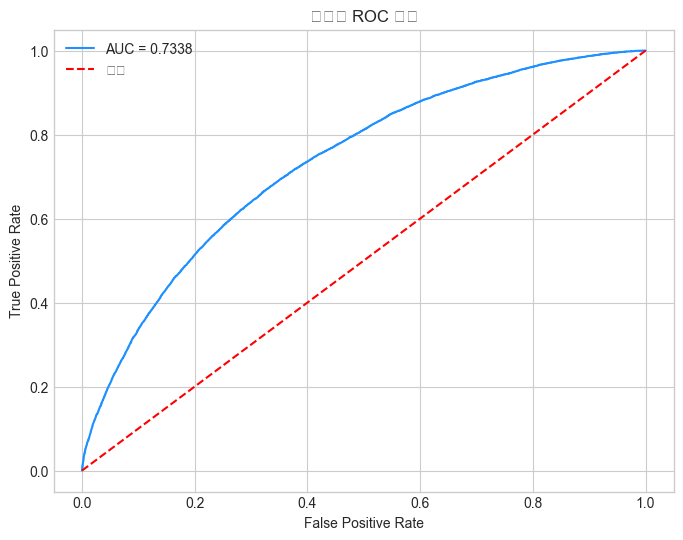

/var/folders/12/hcf280bj3ldfgtx1smbhfk340000gn/T/ipykernel_7630/363821710.py:22: UserWarning:

Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) Arial.

/var/folders/12/hcf280bj3ldfgtx1smbhfk340000gn/T/ipykernel_7630/363821710.py:22: UserWarning:

Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) Arial.

/var/folders/12/hcf280bj3ldfgtx1smbhfk340000gn/T/ipykernel_7630/363821710.py:22: UserWarning:

Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) Arial.

/var/folders/12/hcf280bj3ldfgtx1smbhfk340000gn/T/ipykernel_7630/363821710.py:22: UserWarning:

Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) Arial.

/var/folders/12/hcf280bj3ldfgtx1smbhfk340000gn/T/ipykernel_7630/363821710.py:22: UserWarning:

Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) Arial.

/var/folders/12/hcf280bj3ldfgtx1smbhfk340000gn/T/ipykernel_7630/363821710.py:22: UserWarning:

Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from fo

<Figure size 1000x800 with 0 Axes>

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) Arial.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) Arial.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) Arial.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) Arial.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) Arial.



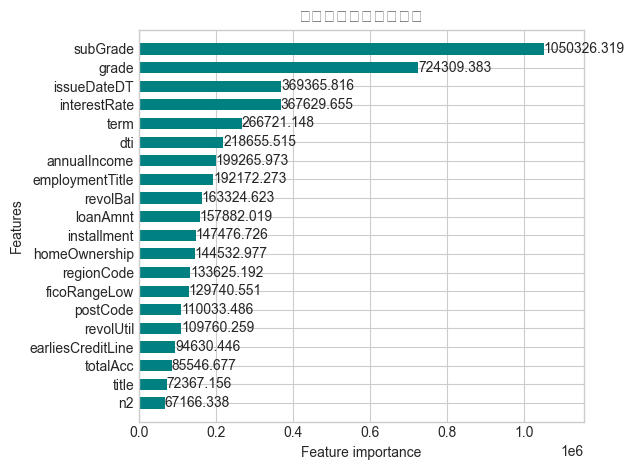

In [52]:
# 验证集 AUC
y_val_pred = final_model.predict_proba(X_val_final)[:, 1]
auc_val = roc_auc_score(y_val_final, y_val_pred)
print(f"✅ 验证集 AUC: {auc_val:.5f}")

# ROC 曲线
fpr, tpr, _ = roc_curve(y_val_final, y_val_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_val:.4f}', color='dodgerblue')
plt.plot([0, 1], [0, 1], 'r--', label='随机')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('验证集 ROC 曲线')
plt.legend()
plt.grid(True)
plt.show()

# 特征重要性图
plt.figure(figsize=(10, 8))
lgb.plot_importance(final_model, max_num_features=20, importance_type='gain', height=0.6, color='teal')
plt.title('特征重要性（按增益）')
plt.tight_layout()
plt.show()

In [53]:
import joblib

joblib.dump(final_model, 'final_lgb_model.pkl')

['final_lgb_model.pkl']

[I 2025-05-21 14:09:11,311] A new study created in memory with name: no-name-3dd0a385-50fd-406d-9247-a3f4980c6413


--- Starting Stage 1: Initial parameter tuning ---


[I 2025-05-21 14:13:36,386] Trial 0 finished with value: 0.7317920202100721 and parameters: {'learning_rate': 0.09431478496358407, 'num_leaves': 83, 'max_depth': 12, 'min_child_samples': 54, 'subsample': 0.6327958372237813, 'colsample_bytree': 0.8771996050678298, 'reg_alpha': 1.1628463437559229, 'reg_lambda': 4.98523144089439}. Best is trial 0 with value: 0.7317920202100721.
[I 2025-05-21 14:14:21,749] Trial 4 finished with value: 0.730847285293091 and parameters: {'learning_rate': 0.09883617144540717, 'num_leaves': 200, 'max_depth': 10, 'min_child_samples': 30, 'subsample': 0.6219608011151421, 'colsample_bytree': 0.9404332400643916, 'reg_alpha': 1.2779992481518683, 'reg_lambda': 1.8108280123942904}. Best is trial 0 with value: 0.7317920202100721.
[I 2025-05-21 14:14:44,253] Trial 3 finished with value: 0.7317893250564176 and parameters: {'learning_rate': 0.08290902882329194, 'num_leaves': 150, 'max_depth': 12, 'min_child_samples': 46, 'subsample': 0.8146513328777211, 'colsample_bytree


--- Stage 1 Results ---
✅ Best parameters tuned in Stage 1:
{'learning_rate': 0.018388109882022982, 'num_leaves': 88, 'max_depth': 5, 'min_child_samples': 89, 'subsample': 0.5155319424498508, 'colsample_bytree': 0.5153579683756078, 'reg_alpha': 4.920248429185694, 'reg_lambda': 2.8183397791158686}
✅ Best AUC from Stage 1: 0.7341

--- Evaluating Stage 1 Best Parameters on a Hold-out Split ---
AUC on Stage 1 evaluation split: 0.7330


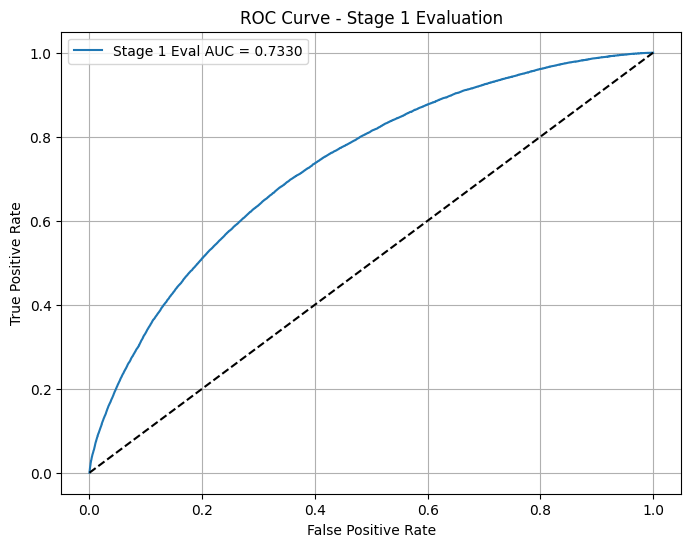

In [11]:
import optuna
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt


# --- Stage 1: Initial tuning of core tree structure and regularization parameters ---
print("--- Starting Stage 1: Initial parameter tuning ---")

def objective_stage1(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'random_state': 42,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=False), # Linear scale for initial LR
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0), # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0), # L2 regularization
        'n_jobs': 5
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []
    for train_idx, valid_idx in skf.split(X_os, y_os):
        X_train_fold, y_train_fold = X_os.iloc[train_idx], y_os.iloc[train_idx]
        X_valid_fold, y_valid_fold = X_os.iloc[valid_idx], y_os.iloc[valid_idx]

        model = lgb.LGBMClassifier(**params, n_estimators=10000) # Fixed n_estimators for this stage
        model.fit(
            X_train_fold, y_train_fold,
            eval_set=[(X_valid_fold, y_valid_fold)],
            eval_metric='auc',
            callbacks=[
                lgb.early_stopping(stopping_rounds=100, verbose=False),
                lgb.log_evaluation(period=0) # Suppress iteration logs
            ]
        )
        y_valid_pred = model.predict_proba(X_valid_fold)[:, 1]
        aucs.append(roc_auc_score(y_valid_fold, y_valid_pred))

    return np.mean(aucs)

study_s1 = optuna.create_study(direction='maximize')
study_s1.optimize(objective_stage1, n_trials=50, n_jobs=5) # n_jobs=5, adjust based on your cores

# Store best parameters from Stage 1 (these are only the ones suggested in the trial)
best_params_s1_tuned = study_s1.best_params.copy()

print("\n--- Stage 1 Results ---")
print("✅ Best parameters tuned in Stage 1:")
print(best_params_s1_tuned)
print(f"✅ Best AUC from Stage 1: {study_s1.best_value:.4f}")

# Optional: Evaluate Stage 1 best parameters on a hold-out split
print("\n--- Evaluating Stage 1 Best Parameters on a Hold-out Split ---")
temp_train_params_s1 = {
    'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt',
    'random_state': 42, 'verbosity': -1,
    **best_params_s1_tuned # Add tuned parameters
}
X_train_eval_s1, X_val_eval_s1, y_train_eval_s1, y_val_eval_s1 = train_test_split(
    X_os, y_os, test_size=0.2, stratify=y_os, random_state=42
)
model_eval_s1 = lgb.LGBMClassifier(**temp_train_params_s1, n_estimators=10000)
model_eval_s1.fit(
    X_train_eval_s1, y_train_eval_s1,
    eval_set=[(X_val_eval_s1, y_val_eval_s1)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(100, verbose=False), lgb.log_evaluation(0)]
)
y_val_pred_eval_s1 = model_eval_s1.predict_proba(X_val_eval_s1)[:, 1]
auc_eval_s1 = roc_auc_score(y_val_eval_s1, y_val_pred_eval_s1)
print(f"AUC on Stage 1 evaluation split: {auc_eval_s1:.4f}")

fpr_s1, tpr_s1, _ = roc_curve(y_val_eval_s1, y_val_pred_eval_s1)
plt.figure(figsize=(8, 6))
plt.plot(fpr_s1, tpr_s1, label=f'Stage 1 Eval AUC = {auc_eval_s1:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Stage 1 Evaluation")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# --- Stage 2: More comprehensive tuning, including boosting_type and other parameters ---
# This stage re-tunes some parameters from Stage 1 with potentially different ranges
# and adds new ones. Its results will supersede Stage 1 for common parameters.
print("\n--- Starting Stage 2: Comprehensive parameter tuning ---")

def objective_stage2(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'random_state': 42, # Added for consistency within lgb.cv if not overridden by folds' random_state
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 15), # Can be -1 for no limit
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100), # Also known as min_data_in_leaf
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-5, 1.0, log=True), # Increased upper bound slightly
        'subsample': trial.suggest_float('subsample', 0.5, 1.0), # Row subsampling
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7), # Frequency for subsampling
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0), # Column subsampling per tree
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True), # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True), # L2 regularization
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0), # Minimum gain to perform split
        'random_state': 42,
        'num_threads': 5
    }

    if params['boosting_type'] == 'dart':
        params['drop_rate'] = trial.suggest_float('drop_rate', 0.05, 0.3) # Adjusted DART params range
        params['skip_drop'] = trial.suggest_float('skip_drop', 0.1, 0.5)
    
    # Ensure subsample_freq is valid if subsample is less than 1.0
    if params['subsample'] < 1.0 and params['subsample_freq'] == 0:
        params['subsample_freq'] = 1 # Set to a default valid value like 1 to enable subsampling

    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # lgb.Dataset is not strictly necessary here if X_os, y_os are directly usable by lgb.cv,
    # but it's good practice if you have categorical features to specify later.
    # For lgb.cv, X_os and y_os are passed directly if folds is a CV iterator.

    cv_results = lgb.cv(
        params,
        lgb.Dataset(X_os, label=y_os), # Using lgb.Dataset explicitly
        num_boost_round=2000, # Increased iterations for more thorough search
        folds=cv_strategy,
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False), lgb.log_evaluation(period=0)],
        stratified=True, # Already handled by StratifiedKFold, but good to be explicit
        seed=42 # For reproducibility of other LGM internal randomness
    )

    metric_key = f"valid {params['metric']}-mean"
    
    if not cv_results[metric_key]:
        print(f"Warning: Metric key '{metric_key}' list of scores is empty. Trial: {trial.number}")
        return 0.0 # Optuna expects a float, indicating a poor result
            
    return max(cv_results[metric_key]) # Return the best mean AUC score from CV

study_s2 = optuna.create_study(direction='maximize')
# Enqueueing Stage 1's best parameters as an initial trial for Stage 2
# Note: enqueue_trial expects a dict of ONLY the parameters defined in the objective's trial.suggest calls
# So, we need to ensure best_params_s1_tuned only contains those.
# If Stage 2 tunes ALL of Stage 1's params plus more, we might need to construct this enqueued trial carefully.
# For simplicity, assuming Stage 1 params are a subset of Stage 2 tunable params OR that Stage 2 is a fresh, broader search.
# The current setup re-tunes all common parameters.
# Let's construct a trial params dict from best_params_s1_tuned that matches objective_stage2's suggestions
s1_params_for_s2_enqueue = {}
for p_name, p_value in best_params_s1_tuned.items():
    if p_name in ['learning_rate', 'num_leaves', 'max_depth', 'min_child_samples', 
                  'subsample', 'colsample_bytree', 'reg_alpha', 'reg_lambda']: # Params common to both
        s1_params_for_s2_enqueue[p_name] = p_value
# Add defaults or plausible values for params in Stage 2 but not in Stage 1 for the enqueued trial
s1_params_for_s2_enqueue.setdefault('boosting_type', 'gbdt')
s1_params_for_s2_enqueue.setdefault('min_child_weight', 0.001) # Example default
s1_params_for_s2_enqueue.setdefault('subsample_freq', 0 if s1_params_for_s2_enqueue.get('subsample', 1.0) == 1.0 else 1)
s1_params_for_s2_enqueue.setdefault('min_split_gain', 0.0)

if s1_params_for_s2_enqueue: # Only enqueue if we successfully constructed it
    study_s2.enqueue_trial(s1_params_for_s2_enqueue)

study_s2.optimize(objective_stage2, n_trials=50, n_jobs=5) # n_trials can be increased
best_params_s2_cumulative = study_s2.best_params.copy()
# best_params_s2_cumulative now holds the best combination found in Stage 2,
# effectively superseding Stage 1 for any commonly tuned parameters.

print("\n--- Stage 2 Results ---")
print("✅ Best parameters found in Stage 2 (comprehensive search):")
print(best_params_s2_cumulative)
print(f"✅ Best AUC from Stage 2: {study_s2.best_value:.4f}")


[I 2025-05-22 14:49:42,325] A new study created in memory with name: no-name-30145502-f2b3-45f7-a41b-14965932c81f



--- Starting Stage 2: Comprehensive parameter tuning ---


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


In [ ]:
# --- Stage 3: Fine-tuning key parameters like learning_rate and regularization ---
print("\n--- Starting Stage 3: Fine-tuning specific parameters ---")

# Parameters from Stage 2 form the base for this stage.
base_params_s3 = best_params_s2_cumulative.copy()

def objective_stage3(trial: optuna.Trial):
    # Start with a copy of the best parameters from Stage 2
    params = base_params_s3.copy()

    # Update only the parameters we want to fine-tune in this stage
    params.update({
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05, log=True), # Narrower, lower LR range
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50), # Potentially finer tune
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 20.0, log=True), # Wider range for regularization
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 20.0, log=True),
        # Other parameters like num_leaves, max_depth, subsample, colsample_bytree are fixed from Stage 2's best
    })
    
    # Add fixed essential parameters not tuned by Optuna but needed by LightGBM
    params['objective'] = 'binary'
    params['metric'] = 'auc'
    params['verbosity'] = -1
    params['random_state'] = 42
    # 'boosting_type' is already in base_params_s3 from Stage 2

    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    cv_results = lgb.cv(
        params,
        lgb.Dataset(X_os, label=y_os),
        num_boost_round=10000, # High number of rounds for low learning rates
        folds=cv_strategy,
        stratified=True,
        seed=42,
        callbacks=[
            lgb.early_stopping(stopping_rounds=200, verbose=False), # More patience for fine-tuning
            lgb.log_evaluation(period=0)
        ]
    )
    
    metric_key = f"valid {params['metric']}-mean"
    if not cv_results[metric_key]:
        print(f"Warning: Metric key '{metric_key}' list of scores is empty. Trial: {trial.number}")
        return 0.0
            
    return max(cv_results[metric_key])

study_s3 = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42)) # TPESampler is default, seed for reproducibility
# Enqueue the best from Stage 2 as a starting point for Stage 3's fine-tuning
# Construct the trial dict carefully to only include what objective_stage3 suggests
s2_params_for_s3_enqueue = {
    'learning_rate': base_params_s3['learning_rate'],
    'min_child_samples': base_params_s3['min_child_samples'],
    'reg_lambda': base_params_s3['reg_lambda'],
    'reg_alpha': base_params_s3['reg_alpha'],
}
study_s3.enqueue_trial(s2_params_for_s3_enqueue)

study_s3.optimize(objective_stage3, n_trials=30, n_jobs=5) # n_trials can be adjusted

# Combine fixed parameters from Stage 2 with parameters tuned in Stage 3
best_params_s3_cumulative = base_params_s3.copy()
best_params_s3_cumulative.update(study_s3.best_params) # study_s3.best_params only has LR, MCS, RL, RA

print("\n--- Stage 3 Results ---")
print("✅ Best parameters fine-tuned in Stage 3:")
print(study_s3.best_params) # Shows only what was tuned in this stage
print("✅ Cumulative best parameters after Stage 3:")
print(best_params_s3_cumulative)
print(f"✅ Best AUC from Stage 3: {study_s3.best_value:.4f}")

[I 2025-05-21 21:38:25,991] A new study created in memory with name: no-name-2d066008-69c9-448d-a735-d8e2388c0807



--- Starting Stage 3: Fine-tuning specific parameters ---


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/optuna/trial/_trial.py:652: UserWarning: Fixed parameter 'min_child_samples' with value 69 is out of range for distribution IntDistribution(high=50, log=False, low=5, step=1).
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/optuna/trial/_trial.py:652: UserWarning: Fixed parameter 'reg_lambda' with value 2.488717438499973e-07 is out of range for distribution FloatDistribution(high=20.0, log=True, low=0.001, step=None).
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/optuna/trial/_trial.py:652: UserWarning: Fixed parameter 'reg_alpha' with value 7.324411464675775e-07 is out of range for distribution FloatDistribution(high=20.0, log=True, low=0.001, step=None).
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:877: UserWarning: The gr

In [ ]:
# --- Stage 4: Final Model Training ---
print("\n--- Starting Stage 4: Training the Final Model ---")

# Split a small portion of X_os, y_os for early stopping in the final model training
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_os, y_os, test_size=0.1, random_state=42, stratify=y_os # Using 10% for final validation
)

# Use the cumulative best parameters from Stage 3
# Add n_estimators, and ensure all other necessary fixed params are set
final_train_params = best_params_s3_cumulative.copy()
final_train_params.update({
    'objective': 'binary',
    'metric': 'auc',
    'random_state': 42,
    'n_jobs': 5, # Use 5 cores for final training
    'verbosity': -1,
    'n_estimators': 10000 # Set a large number, early stopping will find the optimal
})
# 'boosting_type' should already be in final_train_params from Stage 2/3 accumulation

print("\nParameters for final model training:")
for k, v in final_train_params.items():
    print(f"{k}: {v}")

final_model = lgb.LGBMClassifier(**final_train_params)
final_model.fit(
    X_train_final, y_train_final,
    eval_set=[(X_val_final, y_val_final)],
    eval_metric='auc', # Redundant if 'metric' in params, but good for clarity
    callbacks=[
        lgb.early_stopping(stopping_rounds=200, verbose=True), # Print early stopping status
        lgb.log_evaluation(period=100) # Log every 100 rounds for final model
    ]
)

# Get the actual number of estimators used
optimal_n_estimators = final_model.best_iteration_
if optimal_n_estimators is None: # If early stopping didn't trigger (e.g. n_estimators too small)
    optimal_n_estimators = final_train_params['n_estimators']
print(f"\n✅ Optimal n_estimators (determined by early stopping): {optimal_n_estimators}")

# Update final_params with the optimal n_estimators for saving or reporting
final_params_for_deployment = final_train_params.copy()
final_params_for_deployment['n_estimators'] = optimal_n_estimators

print("\n✅ Final Tuned Parameters for Deployment (including optimal n_estimators):")
for k, v in final_params_for_deployment.items():
    print(f"{k}: {v}")

# Evaluate the final model (optional, on the validation set used for early stopping)
y_val_final_pred = final_model.predict_proba(X_val_final)[:, 1]
final_auc_on_val = roc_auc_score(y_val_final, y_val_final_pred)
print(f"\nAUC of final model on its validation set: {final_auc_on_val:.4f}")

# Plot ROC for the final model
fpr_final, tpr_final, _ = roc_curve(y_val_final, y_val_final_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr_final, tpr_final, label=f'Final Model AUC on Val = {final_auc_on_val:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Final Model")
plt.legend()
plt.grid(True)
plt.show()

# To save the final model:
# final_model.booster_.save_model('final_lgbm_model.txt')
# print("\nFinal model saved to 'final_lgbm_model.txt'")